# CS439 Final Project
### Gilad Bejarano (gb534)
### May 8, 2025
### English Premier League Match Prediction System

##### Initialize Dataframe and Inspect Data

In [74]:
import pandas as pd 
import numpy as np

df = pd.concat([pd.read_csv("data/premfull23_24.csv"), pd.read_csv("data/premfull2024_25.csv")], ignore_index=True)
print(df.info(), df.shape, df.columns)
print(df.describe())
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 188 entries, Date to Won%_ForAway
dtypes: float64(154), int64(18), object(16)
memory usage: 690.4+ KB
None (470, 188) Index(['Date', 'Time', 'Day', 'Comp', 'Round_For', 'Venue', 'Result_For',
       'HomeTeam', 'AwayTeam', 'HomeGoals',
       ...
       'CrdY_ForAway', 'CrdR_ForAway', '2CrdY_ForAway', 'Fls_ForAway',
       'PKwon_ForAway', 'PKcon_ForAway', 'OG_ForAway', 'Recov_ForAway',
       'Won_ForAway', 'Won%_ForAway'],
      dtype='object', length=188)
        HomeGoals   AwayGoals      xG_For     xGA_For    Poss_For      Sh_For  \
count  470.000000  470.000000  470.000000  470.000000  470.000000  470.000000   
mean     1.744681    1.461702    1.728936    1.337021   51.314894   15.038298   
std      1.347320    1.234551    0.938704    0.782151   13.324505    6.189838   
min      0.000000    0.000000    0.100000    0.000000   20.000000    1.000000   
25%      1.000000    1.000000    1.000000    0.8000

,Date,Time,Day,Comp,Round_For,Venue,Result_For,HomeTeam,AwayTeam,HomeGoals,...,CrdY_ForAway,CrdR_ForAway,2CrdY_ForAway,Fls_ForAway,PKwon_ForAway,PKcon_ForAway,OG_ForAway,Recov_ForAway,Won_ForAway,Won%_ForAway
0,2023-08-11,20:00,Fri,Premier League,Matchweek 1,Home,L,Burnley,Manchester City,0,...,0,0,0,8.0,0.0,0.0,0.0,54.0,13.0,50.0
1,2023-08-12,12:30,Sat,Premier League,Matchweek 1,Home,W,Arsenal,Nott'ham Forest,2,...,2,0,0,6.0,0.0,0.0,0.0,43.0,14.0,60.9
2,2023-08-12,15:00,Sat,Premier League,Matchweek 1,Home,L,Sheffield United,Crystal Palace,0,...,2,0,0,12.0,0.0,0.0,0.0,34.0,20.0,62.5
3,2023-08-12,17:30,Sat,Premier League,Matchweek 1,Home,W,Newcastle United,Aston Villa,5,...,4,0,0,14.0,0.0,0.0,0.0,52.0,29.0,64.4
4,2023-08-12,15:00,Sat,Premier League,Matchweek 1,Home,W,Brighton and Hove Albion,Luton Town,4,...,4,0,0,17.0,0.0,0.0,0.0,44.0,6.0,54.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2024-10-26,15:00,Sat,Premier League,Matchweek 9,Home,D,Brighton and Hove Albion,Wolves,2,...,3,0,0,10.0,0.0,0.0,0.0,46.0,15.0,57.7
466,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,Chelsea,Newcastle Utd,2,...,2,0,0,14.0,0.0,0.0,0.0,31.0,11.0,37.9
467,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,Crystal Palace,Tottenham,1,...,3,0,0,16.0,0.0,0.0,0.0,37.0,14.0,51.9
468,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,West Ham United,Manchester Utd,2,...,1,0,0,7.0,0.0,1.0,0.0,41.0,14.0,51.9


##### Preprocess and manipulate data

In [75]:
from helpers import compute_team_cumulative
from sklearn.preprocessing import LabelEncoder

#Create column to show points gained from result - necessary for form column
homeresult = {'W': 3, 'D': 1, 'L': 0}
awayresult = {'W': 0, 'D': 1, 'L': 3}
df['HomePoints'] = df['Result_For'].map(homeresult)
df['AwayPoints'] = df['Result_For'].map(awayresult)

#Convert all stat columns to numeric (errors forced to NaN)
df = df.apply(pd.to_numeric, errors='ignore')
numeric_cols = df.select_dtypes(include='number').columns.tolist()
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

#Identify stats relevant to home vs away team
home_stat_cols = [col for col in df.columns if col.endswith('_For') and col in numeric_cols]
home_stat_cols.append("HomeGoals")
away_stat_cols = [col for col in df.columns if col.endswith('_ForAway') and col in numeric_cols]
away_stat_cols.append("AwayGoals")

#Call cumulative stat computation function
home_cumulative = compute_team_cumulative(df, 'HomeTeam', home_stat_cols)
away_cumulative = compute_team_cumulative(df, 'AwayTeam', away_stat_cols)

#Create new df
cumulativeStats = df.copy()
for col in home_stat_cols:
    cumulativeStats[col] = home_cumulative[col]
for col in away_stat_cols:
    cumulativeStats[col] = away_cumulative[col]


#Track results regardless of venue
combined_results = []

#Record results
for idx, row in df.iterrows():
    if pd.notnull(row['HomePoints']):
        combined_results.append({'Team': row['HomeTeam'], 'Index': idx, 'Points': row['HomePoints']})
    if pd.notnull(row['AwayPoints']):
        combined_results.append({'Team': row['AwayTeam'], 'Index': idx, 'Points': row['AwayPoints']})

team_results_df = pd.DataFrame(combined_results).sort_values('Index').reset_index(drop=True)

#Store running results for each team
team_form_history = {}
team_form_lookup = {}

#Form across all matches per team
for _, row in team_results_df.iterrows():
    team = row['Team']
    match_idx = row['Index']
    points = row['Points']
    if team not in team_form_history:
        team_form_history[team] = []
    #Last 5 games points sum
    form_value = sum(team_form_history[team][-5:])
    team_form_lookup.setdefault(team, {})[match_idx] = form_value
    #Append current result
    team_form_history[team].append(points)

overall_form = []
for idx, row in df.iterrows():
    team_home = row['HomeTeam']
    team_away = row['AwayTeam']
    overall_form.append({
        'HomeTeamForm': team_form_lookup.get(team_home, {}).get(idx, 0),
        'AwayTeamForm': team_form_lookup.get(team_away, {}).get(idx, 0)
    })

form_df = pd.DataFrame(overall_form, index=df.index)
cumulativeStats['HomeTeamForm'] = form_df['HomeTeamForm']
cumulativeStats['AwayTeamForm'] = form_df['AwayTeamForm']
cumulativeStats

/var/folders/hf/z4_rc45n17j37v7vq04jknzw0000gn/T/ipykernel_61130/1389228804.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/var/folders/hf/z4_rc45n17j37v7vq04jknzw0000gn/T/ipykernel_61130/1389228804.py:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cumulativeStats['HomeTeamForm'] = form_df['HomeTeamForm']
/var/folders/hf/z4_rc45n17j37v7vq04jknzw0000gn/T/ipykernel_61130/1389228804.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

,Date,Time,Day,Comp,Round_For,Venue,Result_For,HomeTeam,AwayTeam,HomeGoals,...,PKwon_ForAway,PKcon_ForAway,OG_ForAway,Recov_ForAway,Won_ForAway,Won%_ForAway,HomePoints,AwayPoints,HomeTeamForm,AwayTeamForm
0,2023-08-11,20:00,Fri,Premier League,Matchweek 1,Home,L,Burnley,Manchester City,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,3,0,0
1,2023-08-12,12:30,Sat,Premier League,Matchweek 1,Home,W,Arsenal,Nott'ham Forest,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,0,0,0
2,2023-08-12,15:00,Sat,Premier League,Matchweek 1,Home,L,Sheffield United,Crystal Palace,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,3,0,0
3,2023-08-12,17:30,Sat,Premier League,Matchweek 1,Home,W,Newcastle United,Aston Villa,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,0,0,0
4,2023-08-12,15:00,Sat,Premier League,Matchweek 1,Home,W,Brighton and Hove Albion,Luton Town,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2024-10-26,15:00,Sat,Premier League,Matchweek 9,Home,D,Brighton and Hove Albion,Wolves,1.608696,...,0.086957,0.217391,0.0,47.0,15.913043,52.369565,1,1,8,1
466,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,Chelsea,Newcastle Utd,2.173913,...,0.043478,0.173913,0.086957,46.347826,12.521739,53.013043,3,0,10,8
467,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,Crystal Palace,Tottenham,1.695652,...,0.0,0.130435,0.043478,47.956522,10.347826,46.882609,3,0,2,7
468,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,West Ham United,Manchester Utd,1.608696,...,0.043478,0.130435,0.043478,45.913043,12.565217,50.508696,3,0,6,8


##### Feature Engineering

In [76]:
#Incorporate betting odds for each matchup - better idea of probabilities of outcomes
odds = pd.read_csv("data/PremierLeague.csv").query("Season > '2022-2023' and Date < '2024-10-28'")[['MarketAvgHomeTeam','MarketAvgDraw','MarketAvgAwayTeam']]
odds = odds.reset_index(drop=True)
cumulativeStats = cumulativeStats.reset_index(drop=True)
cumulativeStats['HomeProb'] = odds['MarketAvgHomeTeam'].apply(lambda x: 1/x)
cumulativeStats['DrawProb'] = odds['MarketAvgDraw'].apply(lambda x: 1/x)
cumulativeStats['AwayProb'] = odds['MarketAvgAwayTeam'].apply(lambda x: 1/x)
total = cumulativeStats['HomeProb'] + cumulativeStats['DrawProb'] + cumulativeStats['AwayProb']
cumulativeStats['HomeProb'] /= total
cumulativeStats['DrawProb'] /= total
cumulativeStats['AwayProb'] /= total

#Label Encoding Team Names
le = LabelEncoder()
cumulativeStats['Home_encoded'] = le.fit_transform(cumulativeStats['HomeTeam'])
cumulativeStats['Away_encoded'] = le.fit_transform(cumulativeStats['AwayTeam'])

#Calculate difference in statistics between the 2 teams across most statistics in the df
cumulativeStats['FormDifference'] = cumulativeStats['HomeTeamForm']-cumulativeStats['AwayTeamForm']
cols = cumulativeStats.columns
for_cols = [col for col in cols if col.endswith('_For')]
for_away_cols = [col for col in cols if col.endswith('_ForAway')]
base_for = {col[:-4]: col for col in for_cols}
base_away = {col[:-8]: col for col in for_away_cols}
common_keys = base_for.keys() & base_away.keys()
paired_columns = [(base_for[key], base_away[key]) for key in common_keys]
for home_col, away_col in paired_columns:
    try:
        base_name = home_col[:-4]
        diff_col_name = f'{base_name}Difference'
        cumulativeStats[diff_col_name] = cumulativeStats[home_col] - cumulativeStats[away_col]
        cumulativeStats.drop([home_col,away_col],axis=1,inplace=True)
    except:
        continue

#remove rows with NA values
cumulativeStats = cumulativeStats.dropna()
cumulativeStats

,Date,Time,Day,Comp,Round_For,Venue,Result_For,HomeTeam,AwayTeam,HomeGoals,...,StrDifference,1/3Difference,BlocksDifference,G/ShDifference,PassLiveDifference,ClrDifference,CrdYDifference,PassDifference,xAGDifference,KPDifference
19,2023-08-25,20:00,Fri,Premier League,Matchweek 3,Home,W,Chelsea,Luton Town,1.0,...,0.0,15.0,8.0,0.04,-3.0,4.0,-1.0,4.0,0.4,-4.0
20,2023-08-26,15:00,Sat,Premier League,Matchweek 3,Home,L,Everton,Wolves,0.0,...,0.0,9.0,-2.0,0.0,-4.0,-4.0,-3.0,5.0,0.6,-5.0
21,2023-08-26,15:00,Sat,Premier League,Matchweek 3,Home,W,Manchester United,Nott'ham Forest,1.0,...,0.0,-1.0,-4.0,-0.04,9.0,-10.0,0.0,5.0,1.5,6.0
22,2023-08-26,12:30,Sat,Premier League,Matchweek 3,Home,L,Bournemouth,Tottenham,1.0,...,1.0,16.0,0.0,-0.01,-4.0,-26.0,-2.0,-5.0,-0.9,-1.0
23,2023-08-26,17:30,Sat,Premier League,Matchweek 3,Home,L,Brighton and Hove Albion,West Ham,4.0,...,0.0,23.0,1.0,0.12,24.0,-14.0,0.0,1.0,2.2,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2024-10-26,15:00,Sat,Premier League,Matchweek 9,Home,D,Brighton and Hove Albion,Wolves,1.608696,...,0.043478,8.73913,-2.0,0.00087,2.086957,-10.304348,-0.695652,-0.304348,0.304348,1.347826
466,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,Chelsea,Newcastle Utd,2.173913,...,-0.130435,12.956522,0.173913,-0.002174,5.826087,-2.0,0.782609,-0.086957,0.634783,3.391304
467,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,Crystal Palace,Tottenham,1.695652,...,0.086957,-3.478261,-2.347826,-0.013478,2.391304,-3.043478,-0.130435,1.086957,0.078261,1.869565
468,2024-10-27,14:00,Sun,Premier League,Matchweek 9,Home,W,West Ham United,Manchester Utd,1.608696,...,-0.173913,4.478261,3.086957,-0.017391,2.695652,-2.086957,-0.608696,0.565217,0.095652,1.173913


##### Find correlation between result and other statistics

/var/folders/hf/z4_rc45n17j37v7vq04jknzw0000gn/T/ipykernel_61130/118741688.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  cumulativeStats = cumulativeStats.apply(pd.to_numeric, errors='ignore')


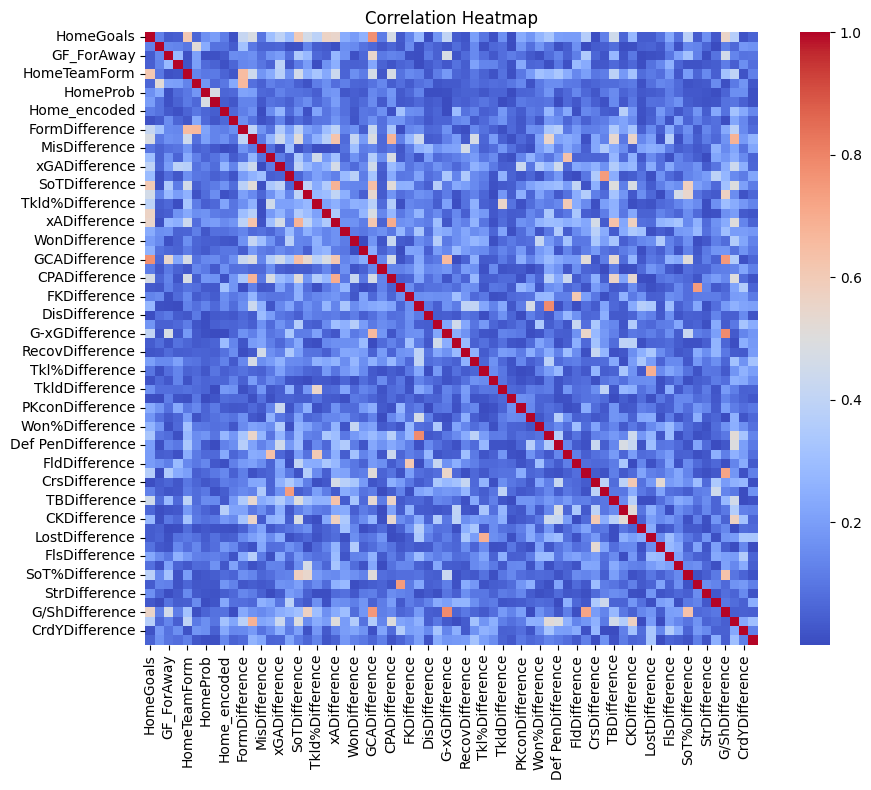

In [77]:
#Find correlations of home points with different statistics, good for finding features to model on later
cumulativeStats = cumulativeStats.apply(pd.to_numeric, errors='ignore')
correlations = cumulativeStats.corr(numeric_only=True)#['HomePoints'].drop('HomePoints').drop('AwayPoints')

corr_matrix = correlations.abs()#df.corr(numeric_only=True).abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

numeric_df = cumulativeStats.select_dtypes(include=[np.number])
df_reduced = numeric_df.drop(columns=to_drop).drop(['HomePoints'],axis=1)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_reduced.corr(numeric_only=True).abs(), fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


##### Split Data into Training and Testing, define target and features

In [78]:
target = "HomePoints"
features = df_reduced.columns.tolist()#correlations.abs().sort_values(ascending=False).index.tolist()
#Make sure certain columns are in the features list
features.extend(["HomeTeamForm","AwayTeamForm","Home_encoded","Away_encoded","HomeProb","AwayProb","DrawProb","FormDifference"])
#remove duplicates from features list
features = list(set(features))
print(features)
print(len(features))
X = cumulativeStats[features]
y = cumulativeStats[target]

# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier()
# model.fit(X, y)
# importances = pd.Series(model.feature_importances_, index=X.columns)
# important_features = importances[importances > 0.01].index.tolist()
# X = cumulativeStats[important_features]

# test train, 20% test
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


['GCADifference', 'CrdRDifference', 'SoT%Difference', 'HomeProb', 'FormDifference', 'DrawProb', 'RecDifference', 'PKwonDifference', 'PassDeadDifference', 'AwayGoals', 'G/ShDifference', 'CrsDifference', 'CrdYDifference', 'DeadDifference', 'FldDifference', 'Away_encoded', 'InDifference', 'G-xGDifference', 'AwayProb', 'GA_ForAway', 'CKDifference', 'Tkld%Difference', 'ErrDifference', 'GF_ForAway', 'OGDifference', 'CrsPADifference', 'npxG/ShDifference', 'xGADifference', 'Mid 3rdDifference', 'TBDifference', 'PassDifference', 'TODifference', 'TkldDifference', 'HomeTeamForm', 'Tkl%Difference', 'Won%Difference', 'BlocksDifference', 'Def 3rdDifference', 'CPADifference', 'G/SoTDifference', 'FlsDifference', 'MisDifference', 'SoTDifference', 'DefDifference', 'AwayTeamForm', 'Home_encoded', 'DisDifference', 'RecovDifference', 'ClrDifference', 'LostDifference', 'HomeGoals', 'OutDifference', 'DistDifference', 'TklDifference', 'xADifference', 'FKDifference', '2CrdYDifference', 'SwDifference', 'IntDiffe

##### Try using a variety of different ways, see what works best

In [79]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Fine tune to find the optimal classifier and parameters
params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 10],'min_samples_split': [2, 5, 10]}
grid = GridSearchCV(RandomForestClassifier(), params, cv=5,scoring="accuracy")
grid.fit(X_train, y_train)
print("Best score:", grid.best_score_)
print(grid.best_params_, grid.best_index_, grid.best_estimator_)

#Use classifier and parameters from GridSearchCV
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
results = pd.DataFrame(y_test)
results['pred'] = y_pred

#Cross Validate for more correct accuracy
scores = cross_val_score(model, X, y, cv=5)
print("Average accuracy:", scores.mean())
print(scores)
results

Best score: 0.5479298245614036
{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100} 0 RandomForestClassifier(max_depth=3)
Average accuracy: 0.5215270684371808
[0.48314607 0.49438202 0.5505618  0.55681818 0.52272727]


,HomePoints,pred
403,0,0
404,1,0
405,1,3
406,3,0
407,1,3
...,...,...
465,1,3
466,3,3
467,3,3
468,3,3


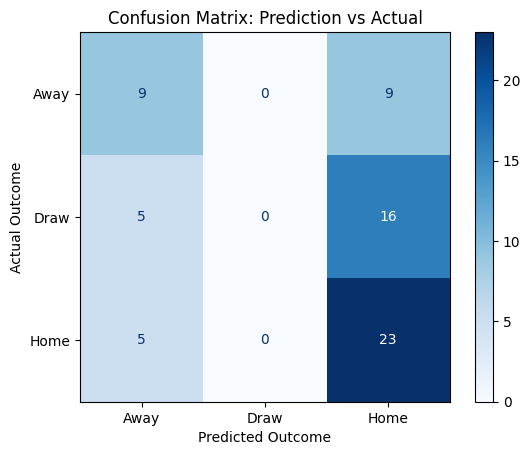

              precision    recall  f1-score   support

        Away       0.47      0.50      0.49        18
        Draw       0.00      0.00      0.00        21
        Home       0.48      0.82      0.61        28

    accuracy                           0.48        67
   macro avg       0.32      0.44      0.36        67
weighted avg       0.33      0.48      0.38        67



/Users/giladbejarano/Desktop/Final Project/Code/finalProject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/giladbejarano/Desktop/Final Project/Code/finalProject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/giladbejarano/Desktop/Final Project/Code/finalProject/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#Sort labels to keep consistent axis order
labels = [0, 1, 3]

#Compute and plot
cm = confusion_matrix(results['HomePoints'], results['pred'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away', 'Draw', 'Home'])

disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Prediction vs Actual')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.show()
print(classification_report(results['HomePoints'], results['pred'], target_names=['Away', 'Draw', 'Home']))

##### Walk forward method, training set constantly shifts, model constantly changing

In [84]:
from sklearn.metrics import accuracy_score
import numpy as np

#Define model
#model = grid.best_estimator_
#Class weights in order to encourage prediction of draws and away, due to heavy bias toward home
#class_weights = {0: 1.1, 1: 1.5, 2: 1}
model = RandomForestClassifier(max_depth=grid.best_params_['max_depth'], n_estimators=grid.best_params_['n_estimators'],min_samples_split=grid.best_params_['min_samples_split'])


window_size = 300
step_size = 1
X = cumulativeStats[features]
y = cumulativeStats[target]

label_map = {0: 0, 1: 1, 3: 2}
inverse_map = {v: k for k, v in label_map.items()}
y_mapped = y.map(label_map)
accuracies = []
predictions = []
actual = []
for i in range(window_size, len(X)-1, step_size):
    X_train = X.iloc[i-window_size:i]
    y_train = y_mapped.iloc[i-window_size:i]
    
    X_test = X.iloc[i:i+1]
    y_test = y_mapped.iloc[i:i+1]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    actual.append(inverse_map[y_test.item()])
    predictions.append(inverse_map[y_pred.item()])   

comparison = pd.DataFrame({'actual':actual,'predictions':predictions})
# Final performance
average_accuracy = np.mean(accuracies)
print(f"Walk-forward average accuracy: {average_accuracy:.3f}")


Walk-forward average accuracy: 0.556


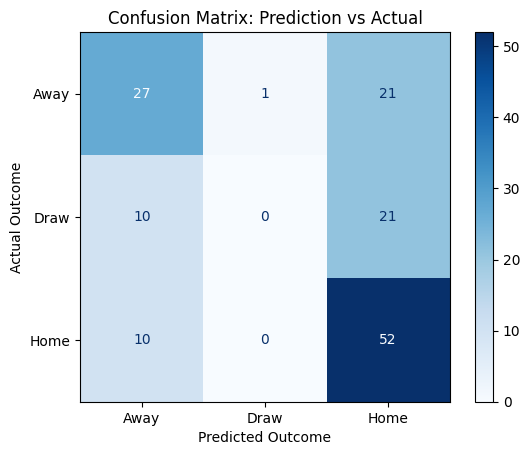

              precision    recall  f1-score   support

        Away       0.57      0.55      0.56        49
        Draw       0.00      0.00      0.00        31
        Home       0.55      0.84      0.67        62

    accuracy                           0.56       142
   macro avg       0.38      0.46      0.41       142
weighted avg       0.44      0.56      0.49       142



In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


#Sort labels to keep consistent axis order
labels = [0, 1, 3]

#Compute and plot
cm = confusion_matrix(comparison['actual'], comparison['predictions'], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away', 'Draw', 'Home'])

disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Prediction vs Actual')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.show()

print(classification_report(comparison['actual'], comparison['predictions'], target_names=['Away', 'Draw', 'Home']))

##### Will PCA help increase accuracy in this case?

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

model_raw = grid.best_estimator_
model_pca = grid.best_estimator_

acc_raw = cross_val_score(model_raw, X, y, cv=5).mean()
acc_pca = cross_val_score(model_pca, X_pca, y, cv=5).mean()

print(f"Accuracy without PCA: {acc_raw:.3f}")
print(f"Accuracy with PCA:    {acc_pca:.3f}")

Accuracy without PCA: 0.528
Accuracy with PCA:    0.517
